# Quarterback Passing Yards/Game Predictive Modeling

## Importing Passer Data

In [6]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

# Stats Stuff
from scipy import stats
from scipy.stats import skew
import statsmodels.api as sm


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)


In [7]:
schedule = nfl.import_schedules([2024])

In [8]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2025), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [9]:
passer_data

,game_id,passer_player_name,posteam,defteam,season,week,home_team,away_team,air_yards,yards_after_catch,epa,complete_pass,incomplete_pass,interception,qb_hit,sack,pass_touchdown,passing_yards,cpoe,roof,surface
4,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,11.0,NaN,-1.542538,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-63.542004,outdoors,grass
7,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,4.0,4.0,0.889353,1.0,0.0,0.0,0.0,0.0,0.0,8.0,24.549454,outdoors,grass
8,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,39.0,5.0,2.468265,1.0,0.0,0.0,0.0,0.0,0.0,44.0,71.269318,outdoors,grass
9,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,CHI,BUF,12.0,0.0,1.879388,1.0,0.0,0.0,0.0,0.0,1.0,12.0,53.646080,outdoors,grass
12,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,CHI,BUF,1.0,11.0,0.731470,1.0,0.0,0.0,0.0,0.0,0.0,12.0,19.861258,outdoors,grass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489921,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,-1.0,1.0,-0.272676,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.075715,outdoors,
489922,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,13.0,0.0,0.936383,1.0,0.0,0.0,0.0,0.0,0.0,13.0,37.446724,outdoors,
489924,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,29.0,NaN,-0.228033,0.0,1.0,0.0,0.0,0.0,0.0,NaN,-31.641153,outdoors,
489925,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,CIN,WAS,13.0,0.0,1.426387,1.0,0.0,0.0,0.0,0.0,0.0,13.0,38.319050,outdoors,


## Passer Preprocessing & Feature Engineering

In [10]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

In [11]:
# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
passer_df = passer_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [12]:
# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Drop the home_team and away_team columns
passer_df = passer_df.drop(columns=['home_team', 'away_team'])

In [13]:
# Reorder the columns
passer_df = passer_df[['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

In [14]:
# Calculate the exponentially weighted moving average for each feature
passer_df['completion_percentage_ewma'] = passer_df.groupby('passer_player_name')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_attempts_ewma'] = passer_df.groupby('passer_player_name')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['air_yards_ewma'] = passer_df.groupby('passer_player_name')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['yards_after_catch_ewma'] = passer_df.groupby('passer_player_name')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['epa_ewma'] = passer_df.groupby('passer_player_name')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['interception_ewma'] = passer_df.groupby('passer_player_name')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['qb_hit_ewma'] = passer_df.groupby('passer_player_name')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['sack_ewma'] = passer_df.groupby('passer_player_name')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['pass_touchdown_ewma'] = passer_df.groupby('passer_player_name')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['passing_yards_ewma'] = passer_df.groupby('passer_player_name')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

passer_df['cpoe_ewma'] = passer_df.groupby('passer_player_name')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [15]:
# Drop the non-ewma columns
passer_df = passer_df.drop(columns=['completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe'])

## Defense Preprocessing & Feature Engineering

In [16]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

In [17]:
# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

In [18]:
# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
defense_df = defense_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [19]:
# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Drop the home_team and away_team columns
defense_df = defense_df.drop(columns=['home_team', 'away_team'])

In [20]:
# Reorder the columns
defense_df = defense_df[['defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

In [21]:
# Calculate the exponentially weighted moving average for each feature
defense_df['completion_percentage_ewma'] = defense_df.groupby('defteam')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_attempts_ewma'] = defense_df.groupby('defteam')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['air_yards_ewma'] = defense_df.groupby('defteam')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['yards_after_catch_ewma'] = defense_df.groupby('defteam')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['epa_ewma'] = defense_df.groupby('defteam')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['interception_ewma'] = defense_df.groupby('defteam')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['qb_hit_ewma'] = defense_df.groupby('defteam')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['sack_ewma'] = defense_df.groupby('defteam')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['pass_touchdown_ewma'] = defense_df.groupby('defteam')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['passing_yards_ewma'] = defense_df.groupby('defteam')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

defense_df['cpoe_ewma'] = defense_df.groupby('defteam')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

In [22]:
# Drop the non-ewma columns
defense_df = defense_df.drop(columns=['passing_yards','completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe'])

## Merging Passer & Defense Data

In [23]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_df.merge(defense_df, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))
# Get rid of flukey rows. Jury out on Taysom Hill I guess.
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8)]

filtered_with_ewma

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
0,2014_01_BUF_CHI,E.Manuel,BUF,CHI,2014,1,173.0,False,21.0,outdoors,grass,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598,True,0.761905,21.000000,190.000000,80.000000,0.368607,1.000000,3.000000,1.000000,1.000000,173.000000,11.150598
1,2014_01_BUF_CHI,J.Cutler,CHI,BUF,2014,1,349.0,True,47.0,outdoors,grass,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331,False,0.723404,47.000000,366.000000,190.000000,-6.755498,2.000000,4.000000,2.000000,2.000000,349.000000,2.864331
2,2014_01_CAR_TB,D.Anderson,CAR,TB,2014,1,230.0,False,33.0,outdoors,grass,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589,True,0.727273,33.000000,242.000000,70.000000,8.423189,0.000000,3.000000,1.000000,2.000000,230.000000,9.822589
3,2014_01_CAR_TB,J.McCown,TB,CAR,2014,1,183.0,True,33.0,outdoors,grass,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191,False,0.666667,33.000000,245.000000,45.000000,-10.437736,2.000000,9.000000,3.000000,2.000000,183.000000,0.519191
4,2014_01_CIN_BAL,A.Dalton,CIN,BAL,2014,1,301.0,False,38.0,outdoors,sportturf,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219,True,0.657895,38.000000,262.000000,172.000000,11.252419,0.000000,1.000000,0.000000,1.000000,301.000000,-2.044219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6748,2024_03_PHI_NO,J.Hurts,PHI,NO,2024,3,311.0,False,37.0,dome,sportturf,0.771150,34.502832,241.430646,161.594642,-2.350847,1.049550,6.304153,3.128736,0.404279,276.028508,9.806723,True,0.695370,37.702864,320.912077,165.116990,-4.428504,0.963885,6.015722,3.172964,0.356015,288.028137,3.377774
6749,2024_03_SF_LA,B.Purdy,SF,LA,2024,3,292.0,False,30.0,dome,matrixturf,0.738309,31.253286,319.248695,57.281068,10.390618,0.231710,4.058320,2.192788,2.260245,292.181912,7.473561,True,0.685915,36.503721,334.530816,77.909885,8.116501,0.233649,3.678584,1.377913,2.063135,289.603465,2.527158
6750,2024_03_SF_LA,M.Stafford,LA,SF,2024,3,221.0,True,25.0,dome,matrixturf,0.661731,27.515754,243.125736,98.034767,0.608555,0.090585,6.395725,3.347680,0.807042,231.750317,3.032181,False,0.633160,28.028805,272.863258,77.761778,-0.983938,0.233339,5.455731,2.789464,0.725497,200.224847,1.121569
6752,2024_03_WAS_CIN,J.Burrow,CIN,WAS,2024,3,324.0,True,38.0,outdoors,,0.729274,36.380665,257.093181,115.619849,10.899412,0.016883,4.420252,2.311366,2.494750,292.143028,7.180779,False,0.726086,36.228201,298.165731,112.622051,13.486049,0.225780,3.555400,1.585342,2.570251,300.739734,6.179144


## Removing Outliers

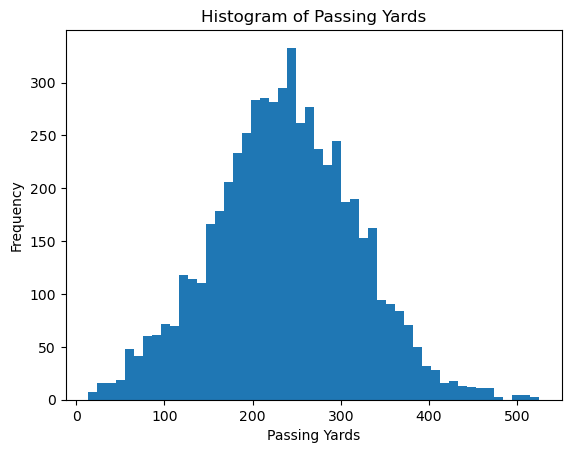

In [24]:
# Identify distribution shape to recreate after we get model results. This looks normal so using our projection for each QB for a week we will use RMSE
# as the standard deviation to create a normal distribution and assign a likelihood to each 
plt.hist(filtered_with_ewma['passing_yards'], bins=50)  # You can adjust the number of bins
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards')
plt.show()

## Exploratory Data Analysis

In [25]:
# Get an overview of the data
filtered_with_ewma.describe().round(2)

,season,week,passing_yards,pass_attempts,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
count,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00,5747.00
mean,2018.68,9.51,236.79,32.16,0.66,31.83,264.05,108.46,0.90,0.75,5.05,2.22,1.46,234.67,0.19,0.66,33.75,280.63,114.52,0.55,0.83,5.41,2.39,1.53,247.68,0.22
std,2.95,5.44,81.26,9.17,0.08,7.51,79.37,36.97,8.03,0.65,2.17,1.27,0.89,66.64,7.01,0.07,5.83,69.62,31.45,7.99,0.68,2.03,1.26,0.82,53.63,6.24
min,2014.00,1.00,14.00,9.00,0.22,6.89,15.00,5.80,-29.73,0.00,0.00,0.00,0.00,22.00,-39.47,0.36,13.93,91.69,31.91,-27.07,0.00,0.00,0.00,0.00,81.57,-28.19
25%,2016.00,5.00,183.00,26.00,0.61,27.23,210.33,83.29,-4.45,0.23,3.49,1.26,0.82,192.20,-4.07,0.61,29.69,231.55,92.29,-4.66,0.25,3.97,1.47,0.92,209.60,-3.79
50%,2019.00,10.00,236.00,32.00,0.66,32.07,260.96,106.76,0.73,0.69,4.83,2.05,1.37,235.58,0.46,0.66,33.49,275.61,111.19,0.85,0.73,5.21,2.24,1.47,245.15,0.30
75%,2021.00,14.00,291.00,38.00,0.71,36.75,314.78,132.32,6.41,1.11,6.39,2.95,2.00,279.99,4.91,0.70,37.47,323.81,134.08,6.04,1.22,6.68,3.13,2.05,283.49,4.47
max,2024.00,22.00,525.00,67.00,1.00,61.00,603.72,250.26,26.29,4.15,14.94,8.25,5.52,483.02,23.10,0.89,61.00,627.07,244.09,27.12,4.01,14.39,8.42,4.96,458.00,20.70


## Modeling w/ Sci-kit Learn

maybe come back to the below cell and figure out how to transform these features into numerical values

In [26]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

In [27]:
# #running on everything to get best params, once I get params take them adn make new model holding out 
# X = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, features]
# y = filtered_with_ewma.loc[filtered_with_ewma['season'] != 2024, target]

# # Select columns for one-hot encoding and standard scaling
# categorical_columns = ['roof', 'surface']
# numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# # Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_columns),
#         ('num', StandardScaler(), numeric_columns)
#     ])

# # Define the parameter grid for tuning
# param_grid = {
#     'num_leaves': [10, 20, 30, 40, 50],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'max_depth': [-1, 5, 10, 15],
#     'min_data_in_leaf': [10, 20, 30, 50, 100],
#     'min_split_gain': [0.0, 0.1, 0.2],
#     'subsample_for_bin': [20000, 30000, 40000],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'bagging_fraction': [0.7, 0.8, 0.9],
#     'feature_fraction': [0.7, 0.8, 0.9],
#     'lambda_l1': [0, 0.1, 0.5, 1],
#     'lambda_l2': [0, 0.1, 0.5, 1],
#     'scale_pos_weight': [1, 10, 20],  # for imbalanced datasets
#     'objective': ['regression'],
#     'boosting_type': ['gbdt', 'dart', 'goss'],  # try different boosting types
#     'n_estimators': [500, 1000, 1500],
#     'metric': ['rmse']
# }

# # Instantiate the LGBM model
# model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42)

# # Define the pipeline with preprocessing and the model
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', model)
# ])

# # Set up Bayesian Search using the pipeline
# opt = BayesSearchCV(
#     estimator=pipeline,  # Use the pipeline in Bayesian optimization
#     search_spaces={'regressor__' + k: v for k, v in param_grid.items()},  # Prefix params with 'regressor__'
#     n_iter=50,  # Number of iterations for Bayesian optimization
#     cv=3,
#     random_state=42,
#     verbose=1,
#     n_jobs=-1  # Use parallel processing
# )

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit the Bayesian optimization search
# opt.fit(X_train, y_train)

# # Get the best parameters
# best_params = opt.best_params_

# # Save best parameters as a dictionary (without 'regressor__' prefix)
# cleaned_best_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

In [28]:
# Define the best parameters from Bayesian optimization
best_params = {
    'bagging_fraction': 0.7,
    'boosting_type': 'goss',
    'colsample_bytree': 0.9,
    'feature_fraction': 0.8,
    'lambda_l1': 1,
    'lambda_l2': 0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'metric': 'rmse',
    'min_data_in_leaf': 10,
    'min_split_gain': 0.2,
    'n_estimators': 1000,
    'num_leaves': 10,
    'objective': 'regression',
    'scale_pos_weight': 10,
    'subsample': 0.9,
    'subsample_for_bin': 30000
}


In [29]:
# Use data for all seasons before 2023 for training
X = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, features]
y = filtered_with_ewma.loc[filtered_with_ewma['season'] <= 2023, target]

In [30]:
# The data for 2024 that we will hold out for final testing
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
y_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, target]

In [31]:
# Ensure there are no missing values in X or y
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Select columns for one-hot encoding and standard scaling
categorical_columns = ['roof', 'surface']
numeric_columns = [item for item in X.columns if item not in ['roof', 'surface']]

# Create a column transformer for preprocessing (OHE for categorical, SS for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Instantiate the LGBM model with the best parameters
model = lgb.LGBMRegressor(**best_params, random_state=42, verbosity=-1)

# Define the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Fit the model to all the data through 2023
pipeline.fit(X, y)

# Evaluate the model on the 2024 data
y_pred_2024 = pipeline.predict(X_2024)

# Print results (e.g., performance metrics)
print(f"2024 set performance: RMSE = {mean_squared_error(y_2024, y_pred_2024, squared=False)}")

2024 set performance: RMSE = 19.123255015755912


In [32]:
# Adding identifier columns back after filtering for 2024 data
X_2024 = filtered_with_ewma.loc[filtered_with_ewma['season'] == 2024, features]
X_2024 = X_2024.merge(filtered_with_ewma[['game_id', 'passer_player_name', 'posteam', 'week']], left_index=True, right_index=True)

In [33]:
# Assuming you have a column like 'game_id' that identifies each game
game_id_column = 'game_id'
passer_column = 'passer_player_name'
team_column = 'posteam'
week_column = 'week'

# Preprocess the 2024 data using the pipeline (no need to use 'preprocessor' step directly)
y_pred_2024 = pipeline.predict(X_2024)

# Create a DataFrame to store predictions along with the game identifier
pred_df = pd.DataFrame({
    game_id_column: X_2024[game_id_column].values,
    passer_column: X_2024[passer_column].values,            # Passer name (QB)
    team_column: X_2024[team_column].values,  # Get the game IDs from X_2024
    week_column: X_2024[week_column].values,  #Week
    'true_passing_yards': y_2024.values,                     # Actual target values
    'predicted_passing_yards': y_pred_2024                   # Predicted values
})

pred_df['pass_yards_oe'] = pred_df['true_passing_yards'] - pred_df['predicted_passing_yards']

In [34]:
pred_df.sort_values('pass_yards_oe', ascending = False)

,game_id,passer_player_name,posteam,week,true_passing_yards,predicted_passing_yards,pass_yards_oe
92,2024_03_NYG_CLE,D.Jones,NYG,3,236.0,193.225352,42.774648
90,2024_03_NE_NYJ,A.Rodgers,NYJ,3,281.0,239.993807,41.006193
67,2024_03_CAR_LV,A.Dalton,CAR,3,319.0,280.241614,38.758386
24,2024_01_NYJ_SF,A.Rodgers,NYJ,1,167.0,130.451047,36.548953
71,2024_03_CHI_IND,C.Williams,CHI,3,363.0,328.505959,34.494041
...,...,...,...,...,...,...,...
78,2024_03_HOU_MIN,C.Stroud,HOU,3,215.0,251.853971,-36.853971
69,2024_03_CAR_LV,G.Minshew,LV,3,214.0,251.794327,-37.794327
63,2024_02_TB_DET,B.Mayfield,TB,2,185.0,225.122614,-40.122614
68,2024_03_CAR_LV,A.O'Connell,LV,3,82.0,125.826550,-43.826550


In [35]:
pred_df.shape

(100, 7)

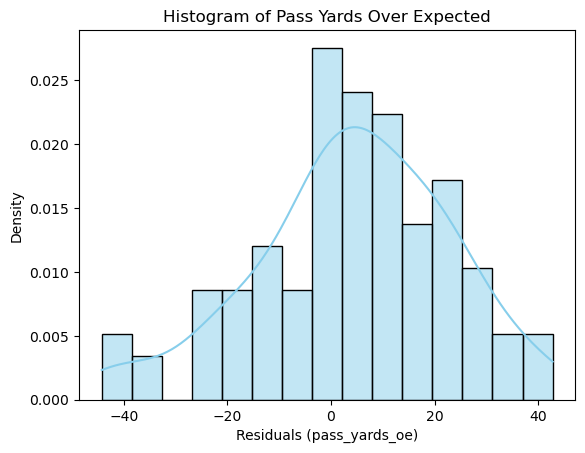

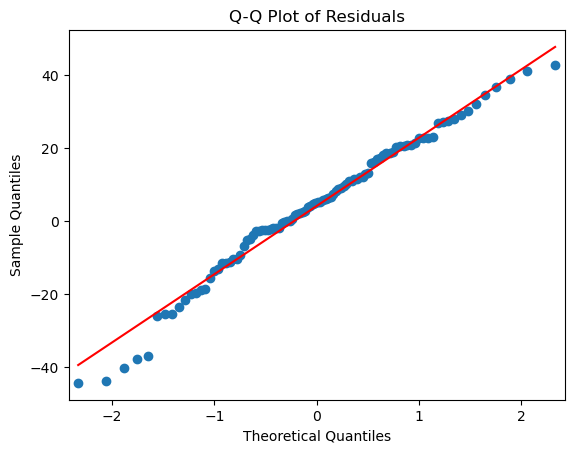

In [37]:
# Assuming 'residuals' is your numpy array of pass_yards_oe
residuals = pred_df['pass_yards_oe'].values

# Histogram and KDE
sns.histplot(residuals, bins=15, kde=True, stat='density', color='skyblue')
plt.title('Histogram of Pass Yards Over Expected')
plt.xlabel('Residuals (pass_yards_oe)')
plt.ylabel('Density')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [38]:
# Fit Normal Distribution
mu_norm, sigma_norm = stats.norm.fit(residuals)

# Fit Student's t-Distribution
df_t, loc_t, scale_t = stats.t.fit(residuals)

# Fit Skew-Normal Distribution
shape_skew, loc_skew, scale_skew = stats.skewnorm.fit(residuals)

# Fit Laplace Distribution
loc_laplace, scale_laplace = stats.laplace.fit(residuals)

In [122]:
def calculate_aic(n_params, log_likelihood):
    return 2 * n_params - 2 * log_likelihood

def calculate_bic(n_params, log_likelihood, n_samples):
    return np.log(n_samples) * n_params - 2 * log_likelihood

n = len(residuals)

# Normal Distribution
loglik_norm = np.sum(stats.norm.logpdf(residuals, mu_norm, sigma_norm))
aic_norm = calculate_aic(2, loglik_norm)
bic_norm = calculate_bic(2, loglik_norm, n)

# t-Distribution
loglik_t = np.sum(stats.t.logpdf(residuals, df_t, loc_t, scale_t))
aic_t = calculate_aic(3, loglik_t)
bic_t = calculate_bic(3, loglik_t, n)

# Skew-Normal Distribution
loglik_skew = np.sum(stats.skewnorm.logpdf(residuals, shape_skew, loc_skew, scale_skew))
aic_skew = calculate_aic(3, loglik_skew)
bic_skew = calculate_bic(3, loglik_skew, n)

# Laplace Distribution
loglik_laplace = np.sum(stats.laplace.logpdf(residuals, loc_laplace, scale_laplace))
aic_laplace = calculate_aic(2, loglik_laplace)
bic_laplace = calculate_bic(2, loglik_laplace, n)

# Compare AIC and BIC
print('AIC Values:')
print(f'Normal: {aic_norm}, t-Distribution: {aic_t}, Skew-Normal: {aic_skew}, Laplace: {aic_laplace}')

print('BIC Values:')
print(f'Normal: {bic_norm}, t-Distribution: {bic_t}, Skew-Normal: {bic_skew}, Laplace: {bic_laplace}')

#lower is better for both

AIC Values:
Normal: 873.2024419434562, t-Distribution: 875.1796351941683, Skew-Normal: 872.0036918933404, Laplace: 878.1573186464956
BIC Values:
Normal: 878.4127823154323, t-Distribution: 882.9951457521327, Skew-Normal: 879.8192024513047, Laplace: 883.3676590184717


In [123]:
from scipy.stats import skew

skewness = skew(residuals)
print(f'Skewness of residuals: {skewness}')

Skewness of residuals: -0.41654265346130487


In [41]:
#we are starting with normal, which like damn bro come on

In [124]:
# Example to calculate residual standard deviation for each QB
def calculate_qb_std(pred_df):
    """
    Calculates the standard deviation of residuals for each quarterback.
    :param pred_df: DataFrame with residuals calculated.
    :return: DataFrame with added 'residual_std' for each QB.
    """
    qb_groups = pred_df.groupby('passer_player_name')['pass_yards_oe']
    pred_df['residual_std'] = qb_groups.transform('std')  # Standard deviation for each QB
    return pred_df

#Assign
pred_df = calculate_qb_std(pred_df)

In [125]:
# Calculate the standard deviation of the residuals
residual_std = np.std(pred_df['pass_yards_oe'], ddof=1)  # ddof=1 ensures it's the sample standard deviation
print(f"Standard Deviation of Residuals: {residual_std}")

Standard Deviation of Residuals: 18.76697815766862


In [126]:
pred_df['residual_std_total'] = residual_std

In [121]:
# pred_df[pred_df['passer_player_name']== 'G.Minshew']

In [127]:
# Function to simulate passing yards for an entire dataframe
def simulate_weekly_passing_yards(df, num_simulations=10000):
    """
    Simulates passing yards for each QB in a given dataframe.
    :param df: pandas DataFrame containing predicted passing yards and residual standard deviation for each QB.
    :param num_simulations: Number of simulations to run per QB.
    :return: DataFrame with simulation results (each row contains a QB's simulations).
    """
    results = {}  # Dictionary to store simulated results
    
    for index, row in df.iterrows():
        qb_name = row['passer_player_name']
        predicted_passing_yards = row['predicted_passing_yards']
        residual_std = row['residual_std_total']
        
        # Simulate passing yards for each QB
        simulated_yards = np.random.normal(loc=predicted_passing_yards, scale=residual_std, size=num_simulations)
        
        # Store the simulation results in the dictionary
        results[qb_name] = simulated_yards
    
    # Convert the dictionary to a DataFrame for easier access and analysis
    simulated_df = pd.DataFrame(results)
    return simulated_df

# # Example usage:
# if __name__ == "__main__":
#     # Sample data for multiple QBs
#     data = {
#         'passer_player_name': ['P.Mahomes', 'J.Herbert', 'J.Allen'],
#         'predicted_passing_yards': [275, 300, 285],
#         'residual_std': [18, 20, 22]  # These could be derived from your residuals analysis
#     }
    
#     # Convert sample data into a DataFrame
#     df = pd.DataFrame(data)
    
#     # Run simulations for all QBs
#     num_simulations = 10000  # Number of simulations per QB
#     simulated_df = simulate_weekly_passing_yards(df, num_simulations)
    
#     # Preview the first few simulations for each QB
#     print(simulated_df.head())
    
#     # Optional: Visualize the results for a specific QB (e.g., P.Mahomes)
#     plt.hist(simulated_df['P.Mahomes'], bins=30, density=True, alpha=0.6, color='blue')
#     plt.title('Simulated Passing Yards for P.Mahomes')
#     plt.xlabel('Passing Yards')
#     plt.ylabel('Density')
#     plt.show()

In [128]:
# Filter the DataFrame for the most recent week
most_recent_week = pred_df['week'].max()
recent_week_df = pred_df[pred_df['week'] == most_recent_week] 

In [129]:
    # Run simulations for all QBs
    num_simulations = 10000  # Number of simulations per QB
    simulated_df = simulate_weekly_passing_yards(recent_week_df, num_simulations)
    
    
    # # Optional: Visualize the results for a specific QB (e.g., P.Mahomes)
    # plt.hist(simulated_df['P.Mahomes'], bins=30, density=True, alpha=0.6, color='blue')
    # plt.title('Simulated Passing Yards for P.Mahomes')
    # plt.xlabel('Passing Yards')
    # plt.ylabel('Density')
    # plt.show()

    simulated_df.sample(10)

,D.Prescott,L.Jackson,A.Dalton,A.O'Connell,G.Minshew,A.Richardson,C.Williams,B.Mayfield,B.Nix,J.Goff,K.Murray,M.Willis,W.Levis,C.Stroud,D.Mills,S.Darnold,J.Allen,T.Lawrence,K.Cousins,P.Mahomes,J.Fields,J.Herbert,G.Smith,S.Thompson,T.Boyle,A.Rodgers,J.Brissett,D.Jones,D.Watson,D.Carr,J.Hurts,B.Purdy,M.Stafford,J.Burrow,J.Daniels
7020,375.488782,190.262356,282.841256,122.037627,260.440563,118.913985,301.143523,189.773445,214.570914,188.357678,220.275878,175.024958,233.187836,255.023127,29.382045,188.168062,283.890602,181.332235,205.441696,208.777497,234.076066,114.466618,310.588759,114.598294,75.606073,242.089320,123.223282,186.777771,201.303955,196.670855,297.000588,300.795883,182.100584,332.262703,259.599805
4798,370.036575,246.836608,291.746528,123.412838,247.844618,127.469108,324.391476,198.209988,240.324931,166.735645,197.169336,188.312033,255.489083,232.461392,45.901503,182.077645,249.824549,181.442256,228.670185,214.837344,208.913967,144.563116,289.609032,79.855787,80.830761,246.434246,106.075641,218.044403,213.129870,154.390203,319.136725,316.021201,239.729736,303.824573,257.880091
9540,359.174674,176.582926,281.678786,117.579362,254.469892,162.751239,332.010510,202.323805,246.417387,222.321018,177.787699,197.603672,226.050252,230.637070,65.326911,200.469762,215.347187,112.419438,188.187008,227.587936,229.530285,124.277999,312.225386,97.341741,88.372878,262.643997,97.477820,206.939218,196.888111,119.624274,307.487493,310.165250,187.396039,293.102444,250.112461
1369,355.094069,170.078563,296.925760,128.224859,271.958716,155.268864,331.720522,184.518040,210.171722,199.133362,225.881271,184.493939,237.514120,237.155030,76.665241,164.334239,248.671512,175.200122,221.001347,214.908802,237.688133,108.667461,276.102119,123.514693,106.772079,219.065241,94.789193,202.283741,219.971046,116.505239,285.085113,306.513929,230.926417,319.764544,262.085259
3337,384.283874,171.110253,288.084308,128.029068,258.006718,167.545347,340.690110,211.891301,235.988978,178.391484,239.469538,198.571360,221.273610,257.866973,61.285758,191.600921,253.635319,179.009022,219.957212,213.531512,237.203909,93.994537,290.409139,110.324326,104.911536,208.923005,161.995957,224.608086,166.459274,109.482951,299.460120,296.673575,226.726755,302.931662,266.097561
3374,360.020815,212.340683,276.005280,118.938732,218.119942,181.119280,366.665276,169.489850,222.295429,229.501342,182.430705,176.268748,243.230493,246.953699,43.553898,208.840619,279.837422,184.872107,196.379091,235.973942,225.870961,121.465626,300.183171,98.990390,80.082686,212.708836,91.980462,174.940733,183.102293,132.774436,289.057782,341.461050,191.751364,299.531830,269.094238
5817,338.376779,190.044898,304.069422,170.877699,210.281745,189.275902,339.415854,208.474142,225.997599,211.156849,208.037271,198.104253,231.710251,229.959137,57.018563,190.365803,260.245015,161.837573,192.130904,195.910355,260.014842,77.512050,341.668208,155.506054,89.886303,234.307203,124.992001,225.371423,215.198525,97.011479,284.610862,321.503206,207.433920,264.879528,247.750174
6483,361.999244,164.989458,282.932486,112.054423,278.452803,163.223470,353.331029,167.425413,238.016225,194.939276,199.732332,146.234516,236.242210,232.319218,65.578428,214.351303,266.204124,173.197974,218.772723,234.698966,205.837106,138.251267,327.355692,113.433073,72.010603,218.769742,74.356652,156.084090,187.418686,126.458346,264.977278,299.618633,183.379429,299.014511,257.380439
4055,344.206346,181.309646,253.134373,148.640857,266.738454,157.443056,306.977166,192.431289,207.034095,226.932460,202.203038,159.634537,222.529220,256.802088,74.129641,178.804955,253.683767,171.449006,216.792923,206.999602,201.632101,98.887956,323.441722,121.254813,81.486558,270.964419,114.505163,206.282800,192.476937,114.419994,281.408365,305.497240,233.124435,339.827883,241.504170
7799,365.317657,177.106657,276.482045,124.185157,258.774831,183.561488,349.418991,144.223826,212.742871,193.443453,205.990997,193.706715,257.148977,244.723509,51.276142,185.802926,250.051

In [130]:
def map_std_to_df(standard_deviation):
    """
    Maps the standard deviation of QB's passing performance to degrees of freedom for the t-distribution.
    :param standard_deviation: The standard deviation of the QB's passing yards or residuals.
    :return: Degrees of freedom (df) for the t-distribution.
    """
    # Example mapping logic
    if standard_deviation > 50:
        return 3  # Very high variance, allow more extreme outcomes
    elif 30 < standard_deviation <= 50:
        return 5  # High variance, some extreme outcomes possible
    elif 20 < standard_deviation <= 30:
        return 7  # Moderate variance
    else:
        return 10  # Low variance, tighter distribution

In [131]:
def get_qb_std(qb_name, pred_df):
    """
    Retrieves the standard deviation of the QB's residuals or passing yards from pred_df.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residuals.
    :return: The standard deviation for the given QB.
    """
    # Ensure the QB exists in the dataframe
    if qb_name not in pred_df['passer_player_name'].values:
        raise ValueError(f"Quarterback {qb_name} not found in pred_df.")
    
    # Get the QB's standard deviation from residuals or passing yards
    qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
    return qb_data['residual_std']  # Assuming residual_std column is already in pred_df

In [136]:
def simulate_passing_yards_with_dynamic_df(qb_name, pred_df, num_simulations=10000):
    """
    Simulates passing yards using a t-distribution with degrees of freedom based on the QB's standard deviation.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
    :param num_simulations: Number of simulations to run.
    :return: Simulated passing yards.
    """
    # Retrieve the QB's standard deviation
    qb_std = get_qb_std(qb_name, pred_df)
    
    # Map the standard deviation to degrees of freedom
    df = map_std_to_df(qb_std)
    
    # Extract the predicted passing yards and residual standard deviation for the QB
    qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']
    
    # Simulate passing yards using the t-distribution with dynamically adjusted df
    simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=residual_std, size=num_simulations)
    
    return simulations, predicted_passing_yards, residual_std

In [137]:
def plot_qb_simulation_curve_with_guess(qb_name, pred_df, user_guess=None, num_simulations=10000):
    """
    Plots the distribution (curve) of simulated passing yards for a given QB using t-distribution,
    and calculates the probability of exceeding the user_guess yards. Adds the prediction line and the guess line.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
    :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
    :param num_simulations: Number of simulations to run.
    """
    # Get the simulated passing yards, prediction, and residual std for the QB
    simulations, predicted_passing_yards, residual_std = simulate_passing_yards_with_dynamic_df(qb_name, pred_df, num_simulations)
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the predicted passing yards line
    plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards")
    
    # Add the user guess line and calculate the probability
    probability = None
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        # Calculate the probability of exceeding the user guess
        probability = np.mean(simulations >= user_guess)
        print(f"Probability of {qb_name} throwing at least {user_guess} yards: {probability:.4f}")
    
    # Plot details
    plt.title(f"Simulated Passing Yards for {qb_name}")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return simulations, probability

In [138]:
# Example usage
qb_name = "P.Mahomes"  # Example quarterback name
simulations = simulate_passing_yards_with_dynamic_df(qb_name, pred_df)

In [139]:
# Example usage
if __name__ == "__main__":
    qb_name = "A.Dalton"  # Example quarterback name
    user_guess = 320  # Example user guess for passing yards (optional)
    
    # Plot the curve for Patrick Mahomes using t-distribution with dynamic df and user guess line
    simulations, probability = plot_qb_simulation_curve_with_guess(qb_name, pred_df, user_guess=user_guess)
    
    if probability is not None:
        print(f"The probability of {qb_name} throwing at least {user_guess} yards is {probability:.4f}")

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.t` documentation for details.

Degrees of freedom (df) for B.Purdy: 10
Probability of B.Purdy throwing at least 320 yards: 0.0000


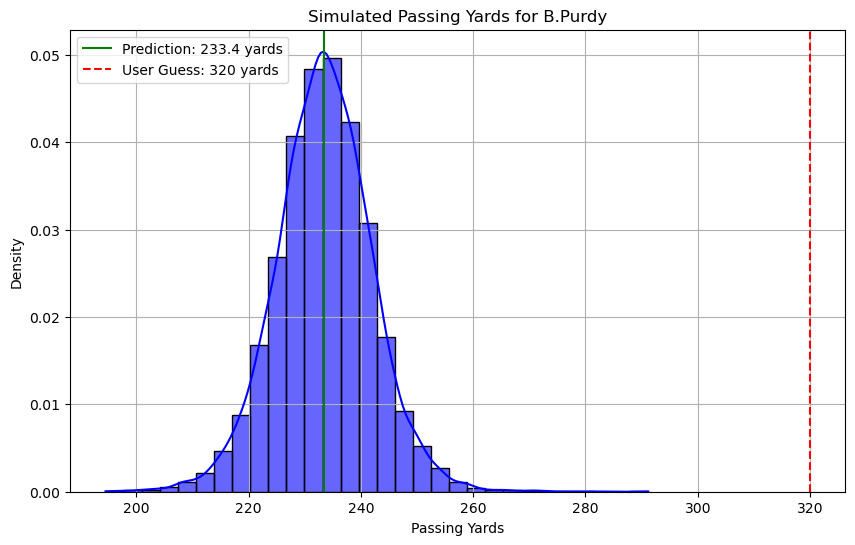

The probability of B.Purdy throwing at least 320 yards is 0.0000


In [144]:
def simulate_passing_yards_with_dynamic_df(qb_name, pred_df, num_simulations=10000):
    """
    Simulates passing yards using a t-distribution with degrees of freedom based on the QB's standard deviation.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
    :param num_simulations: Number of simulations to run.
    :return: Simulated passing yards, predicted passing yards, residual std, and degrees of freedom.
    """
    # Retrieve the QB's standard deviation
    qb_std = get_qb_std(qb_name, pred_df)
    
    # Map the standard deviation to degrees of freedom
    df = map_std_to_df(qb_std)
    
    # Extract the predicted passing yards and residual standard deviation for the QB
    qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']
    
    # Simulate passing yards using the t-distribution with dynamically adjusted df
    simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=residual_std, size=num_simulations)
    
    return simulations, predicted_passing_yards, residual_std, df

def plot_qb_simulation_curve_with_guess(qb_name, pred_df, user_guess=None, num_simulations=10000):
    """
    Plots the distribution (curve) of simulated passing yards for a given QB using t-distribution,
    and calculates the probability of exceeding the user_guess yards. Adds the prediction line and the guess line.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
    :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
    :param num_simulations: Number of simulations to run.
    """
    # Get the simulated passing yards, prediction, residual std, and df for the QB
    simulations, predicted_passing_yards, residual_std, df = simulate_passing_yards_with_dynamic_df(qb_name, pred_df, num_simulations)
    
    # Print the degrees of freedom used for this QB
    print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the predicted passing yards line
    plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards")
    
    # Add the user guess line and calculate the probability
    probability = None
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        # Calculate the probability of exceeding the user guess
        probability = np.mean(simulations >= user_guess)
        print(f"Probability of {qb_name} throwing at least {user_guess} yards: {probability:.4f}")
    
    # Plot details
    plt.title(f"Simulated Passing Yards for {qb_name}")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return simulations, probability

# def map_std_to_df(standard_deviation):
#     """
#     Maps the standard deviation of QB's passing performance to degrees of freedom for the t-distribution.
#     :param standard_deviation: The standard deviation of the QB's passing yards or residuals.
#     :return: Degrees of freedom (df) for the t-distribution.
#     """
#     # Example mapping logic
#     if standard_deviation > 50:
#         return 3  # Very high variance, allow more extreme outcomes
#     elif 30 < standard_deviation <= 50:
#         return 5  # High variance, some extreme outcomes possible
#     elif 20 < standard_deviation <= 30:
#         return 7  # Moderate variance
#     else:
#         return 10  # Low variance, tighter distribution

def map_std_to_df(standard_deviation):
    """
    Maps the standard deviation of QB's passing performance to degrees of freedom for the t-distribution.
    :param standard_deviation: The standard deviation of the QB's passing yards or residuals.
    :return: Degrees of freedom (df) for the t-distribution.
    """
    # Adjusted thresholds based on potentially smaller standard deviations in your dataset
    if standard_deviation > 25:
        return 3  # Very high variance, allow more extreme outcomes
    elif 15 < standard_deviation <= 25:
        return 5  # High variance, some extreme outcomes possible
    elif 10 < standard_deviation <= 15:
        return 7  # Moderate variance
    else:
        return 10  # Low variance, tighter distribution

def get_qb_std(qb_name, pred_df):
    """
    Retrieves the standard deviation of the QB's residuals or passing yards from pred_df.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residuals.
    :return: The standard deviation for the given QB.
    """
    # Ensure the QB exists in the dataframe
    if qb_name not in pred_df['passer_player_name'].values:
        raise ValueError(f"Quarterback {qb_name} not found in pred_df.")
    
    # Get the QB's standard deviation from residuals or passing yards
    qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
    return qb_data['residual_std']  # Assuming residual_std column is already in pred_df

# Example usage
if __name__ == "__main__":
    qb_name = "B.Purdy"  # Example quarterback name
    user_guess = 320  # Example user guess for passing yards (optional)
    
    # Plot the curve for Patrick Mahomes using t-distribution with dynamic df and user guess line
    simulations, probability = plot_qb_simulation_curve_with_guess(qb_name, pred_df, user_guess=user_guess)
    
    if probability is not None:
        print(f"The probability of {qb_name} throwing at least {user_guess} yards is {probability:.4f}")


In [145]:
def get_qb_std(qb_name, pred_df):
    """
    Retrieves the standard deviation of the QB's residuals or passing yards from pred_df.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residuals.
    :return: The standard deviation for the given QB.
    """
    # Ensure the QB exists in the dataframe
    if qb_name not in pred_df['passer_player_name'].values:
        raise ValueError(f"Quarterback {qb_name} not found in pred_df.")
    
    # Get the QB's standard deviation from residuals or passing yards
    qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
    qb_std = qb_data['residual_std']  # Assuming residual_std column is already in pred_df
    
    # Print the standard deviation for debugging purposes
    print(f"Standard deviation for {qb_name}: {qb_std}")
    
    return qb_std

In [146]:

def print_all_qb_std(pred_df):
    """
    Prints the standard deviation of the QB's residuals or passing yards from pred_df for all quarterbacks.
    :param pred_df: DataFrame containing predicted passing yards and residuals for each QB.
    """
    for index, row in pred_df.iterrows():
        qb_name = row['passer_player_name']
        qb_std = row['residual_std']
        print(f"Standard deviation for {qb_name}: {qb_std}")

# Assuming pred_df is available and has 'passer_player_name' and 'residual_std' columns.
# Uncomment and run the function below once pred_df is defined in your environment.
print_all_qb_std(pred_df)

Standard deviation for J.Allen: 12.779161960562554
Standard deviation for K.Murray: 15.996248991519575
Standard deviation for L.Jackson: 5.84311250065797
Standard deviation for P.Mahomes: 11.67829365217583
Standard deviation for B.Young: 22.410735497467208
Standard deviation for D.Carr: 9.936489285491586
Standard deviation for D.Prescott: 18.947880567960148
Standard deviation for D.Watson: 14.187231223095251
Standard deviation for B.Nix: 16.101757982348083
Standard deviation for G.Smith: 23.37995228601294
Standard deviation for J.Hurts: 3.650625951378139
Standard deviation for J.Love: nan
Standard deviation for A.Richardson: 12.03420032164231
Standard deviation for C.Stroud: 21.474484077536935
Standard deviation for T.Lawrence: 10.260965402062801
Standard deviation for T.Tagovailoa: 46.011281612411665
Standard deviation for J.Goff: 11.464527106279249
Standard deviation for M.Stafford: 22.594050221596703
Standard deviation for G.Minshew: 23.824280379831585
Standard deviation for J.Herbe

Standard deviation for P.Mahomes: 11.67829365217583
Degrees of freedom (df) for P.Mahomes: 7
Probability of P.Mahomes throwing at least 320 yards: 0.1286


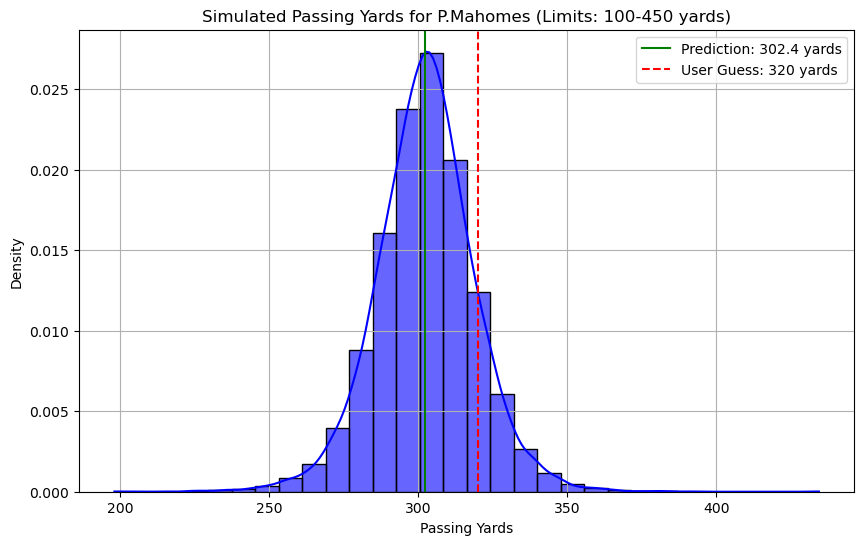

The probability of P.Mahomes throwing at least 320 yards is 0.1286


In [147]:
def simulate_passing_yards_with_limits(qb_name, pred_df, min_yards=100, max_yards=450, scaling_factor=1.2, num_simulations=10000):
    """
    Simulates passing yards using a t-distribution with degrees of freedom based on the QB's standard deviation,
    applies limits to the minimum and maximum passing yards, and scales the standard deviation to widen the curve.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
    :param min_yards: Minimum passing yards limit.
    :param max_yards: Maximum passing yards limit.
    :param scaling_factor: Factor to scale the residual standard deviation to widen the curve.
    :param num_simulations: Number of simulations to run.
    :return: Simulated passing yards, predicted passing yards, residual std, and degrees of freedom.
    """
    # Retrieve the QB's standard deviation
    qb_std = get_qb_std(qb_name, pred_df)
    
    # Map the standard deviation to degrees of freedom
    df = map_std_to_df(qb_std)
    
    # Extract the predicted passing yards and residual standard deviation for the QB
    qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']
    
    # Scale the standard deviation to widen the distribution
    scaled_std = residual_std * scaling_factor
    
    # Simulate passing yards using the t-distribution with dynamically adjusted df
    simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=scaled_std, size=num_simulations)
    
    # Apply minimum and maximum passing yards limits
    simulations = np.clip(simulations, min_yards, max_yards)
    
    return simulations, predicted_passing_yards, scaled_std, df

def plot_qb_simulation_curve_with_guess_and_limits(qb_name, pred_df, user_guess=None, min_yards=100, max_yards=450, scaling_factor=1.2, num_simulations=10000):
    """
    Plots the distribution (curve) of simulated passing yards for a given QB, adds minimum and maximum passing yards limits,
    and calculates the probability of exceeding the user_guess yards. Adds the prediction line and the guess line.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards and residual standard deviation for each QB.
    :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
    :param min_yards: Minimum passing yards limit.
    :param max_yards: Maximum passing yards limit.
    :param scaling_factor: Factor to scale the residual standard deviation to widen the curve.
    :param num_simulations: Number of simulations to run.
    """
    # Get the simulated passing yards, prediction, scaled residual std, and df for the QB
    simulations, predicted_passing_yards, scaled_std, df = simulate_passing_yards_with_limits(qb_name, pred_df, min_yards, max_yards, scaling_factor, num_simulations)
    
    # Print the degrees of freedom used for this QB
    print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the predicted passing yards line
    plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards")
    
    # Add the user guess line and calculate the probability
    probability = None
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        # Calculate the probability of exceeding the user guess
        probability = np.mean(simulations >= user_guess)
        print(f"Probability of {qb_name} throwing at least {user_guess} yards: {probability:.4f}")
    
    # Plot details
    plt.title(f"Simulated Passing Yards for {qb_name} (Limits: {min_yards}-{max_yards} yards)")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return simulations, probability

# Usage example:
if __name__ == "__main__":
    qb_name = "P.Mahomes"  # Example quarterback name
    user_guess = 320  # Example user guess for passing yards
    
    # Plot the curve for Mahomes with t-distribution, scaled std, and limits
    simulations, probability = plot_qb_simulation_curve_with_guess_and_limits(qb_name, pred_df, user_guess=user_guess)
    
    if probability is not None:
        print(f"The probability of {qb_name} throwing at least {user_guess} yards is {probability:.4f}")

League-wide standard deviation of true passing yards: 68.44
Probability of P.Mahomes throwing at least 320 yards: 0.3972


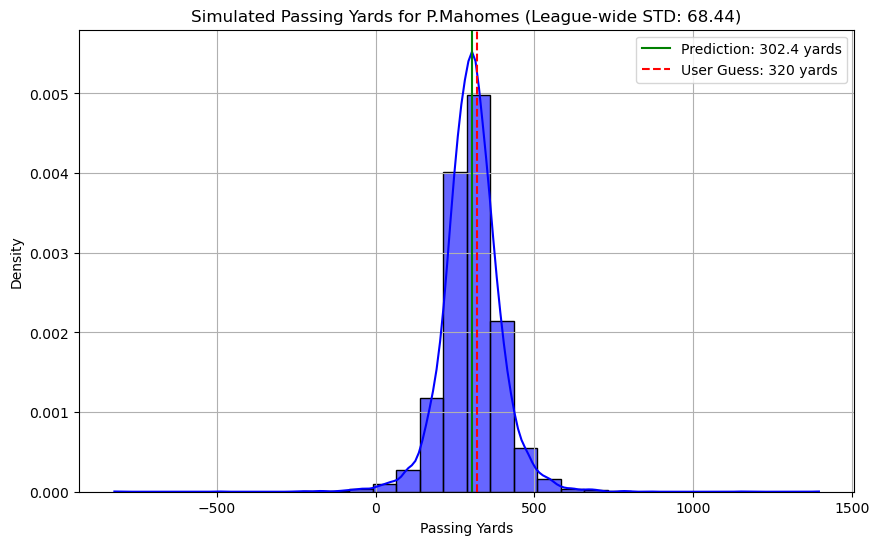

The probability of P.Mahomes throwing at least 320 yards is 0.3972


In [149]:
# def calculate_league_wide_std(pred_df):
#     """
#     Calculates the standard deviation of true passing yards across the entire league.
#     :param pred_df: DataFrame containing true passing yards.
#     :return: League-wide standard deviation of true passing yards.
#     """
#     league_wide_std = np.std(pred_df['true_passing_yards'], ddof=1)  # Sample standard deviation (ddof=1)
#     print(f"League-wide standard deviation of true passing yards: {league_wide_std:.2f}")
#     return league_wide_std

# def simulate_passing_yards_league_std(qb_name, pred_df, league_wide_std, num_simulations=10000):
#     """
#     Simulates passing yards using a t-distribution with the league-wide standard deviation.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param pred_df: DataFrame containing predicted passing yards for each QB.
#     :param league_wide_std: League-wide standard deviation of true passing yards.
#     :param num_simulations: Number of simulations to run.
#     :return: Simulated passing yards, predicted passing yards.
#     """
#     # Extract the predicted passing yards for the QB
#     qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
#     predicted_passing_yards = qb_data['predicted_passing_yards']
    
#     # Simulate passing yards using the t-distribution with league-wide standard deviation
#     simulations = stats.t.rvs(5, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
#     return simulations, predicted_passing_yards

# def plot_qb_simulation_curve_league_std(qb_name, pred_df, league_wide_std, user_guess=None, num_simulations=10000):
#     """
#     Plots the distribution (curve) of simulated passing yards for a given QB using the league-wide standard deviation,
#     and calculates the probability of exceeding the user_guess yards.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param pred_df: DataFrame containing predicted passing yards for each QB.
#     :param league_wide_std: League-wide standard deviation of true passing yards.
#     :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
#     :param num_simulations: Number of simulations to run.
#     """
#     # Get the simulated passing yards and predicted passing yards for the QB
#     simulations, predicted_passing_yards = simulate_passing_yards_league_std(qb_name, pred_df, league_wide_std, num_simulations)
    
#     # Plot the distribution of the simulated passing yards
#     plt.figure(figsize=(10, 6))
#     sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
#     # Add the predicted passing yards line
#     plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards")
    
#     # Add the user guess line and calculate the probability
#     probability = None
#     if user_guess is not None:
#         plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
#         # Calculate the probability of exceeding the user guess
#         probability = np.mean(simulations >= user_guess)
#         print(f"Probability of {qb_name} throwing at least {user_guess} yards: {probability:.4f}")
    
#     # Plot details
#     plt.title(f"Simulated Passing Yards for {qb_name} (League-wide STD: {league_wide_std:.2f})")
#     plt.xlabel("Passing Yards")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return simulations, probability

# # Example usage:
# if __name__ == "__main__":
#     # Calculate league-wide standard deviation
#     league_wide_std = calculate_league_wide_std(pred_df)
    
#     qb_name = "P.Mahomes"  # Example quarterback name
#     user_guess = 320  # Example user guess for passing yards
    
#     # Plot the curve for Mahomes with t-distribution based on league-wide std
#     simulations, probability = plot_qb_simulation_curve_league_std(qb_name, pred_df, league_wide_std, user_guess=user_guess)
    
#     if probability is not None:
#         print(f"The probability of {qb_name} throwing at least {user_guess} yards is {probability:.4f}")

Probability of L.Jackson throwing at least 200 yards: 0.8273


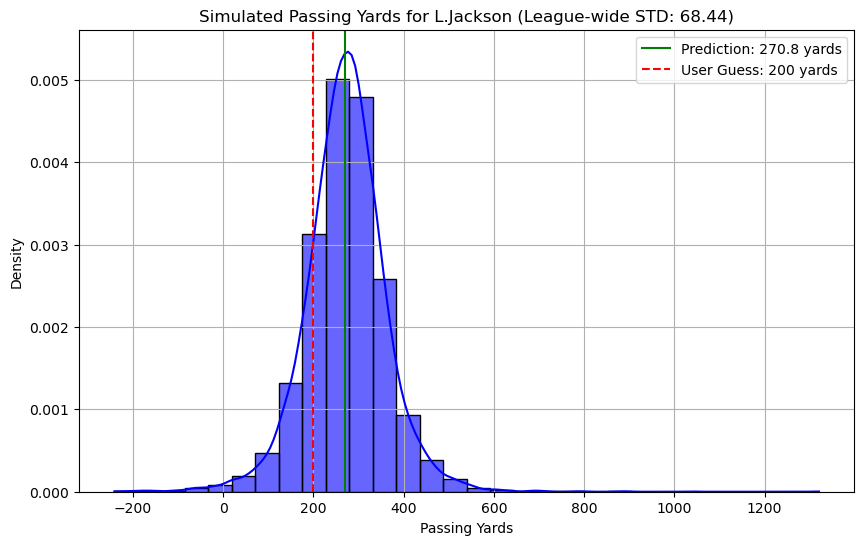

Adjusted probability for <= 100 yards: 2.8600%
Adjusted probability for >= 450 yards: 2.4200%


In [153]:
def apply_minimum_probability(simulations, min_prob_threshold=0.001, min_yards=100, max_yards=450):
    """
    Applies a minimum probability threshold for extreme outcomes (below min_yards and above max_yards).
    :param simulations: The simulated passing yards.
    :param min_prob_threshold: The minimum probability to apply.
    :param min_yards: The lower bound for passing yards.
    :param max_yards: The upper bound for passing yards.
    :return: Adjusted probabilities with minimum thresholds applied.
    """
    # Calculate probabilities for values below min_yards and above max_yards
    prob_below_min = np.mean(simulations <= min_yards)
    prob_above_max = np.mean(simulations >= max_yards)
    
    # Ensure minimum probabilities for extreme outcomes
    adjusted_prob_below_min = max(prob_below_min, min_prob_threshold)
    adjusted_prob_above_max = max(prob_above_max, min_prob_threshold)
    
    print(f"Adjusted probability for <= {min_yards} yards: {adjusted_prob_below_min:.4%}")
    print(f"Adjusted probability for >= {max_yards} yards: {adjusted_prob_above_max:.4%}")
    
    return adjusted_prob_below_min, adjusted_prob_above_max

# Example usage:
if __name__ == "__main__":
    qb_name = "L.Jackson"
    user_guess = 200
    
    # Run the simulations
    simulations, probability = plot_qb_simulation_curve_league_std(qb_name, pred_df, league_wide_std, user_guess=user_guess)
    
    # Apply minimum probability threshold to extreme outcomes
    min_prob_threshold = 0.001  # Set to 0.1%
    adjusted_prob_below_min, adjusted_prob_above_max = apply_minimum_probability(simulations, min_prob_threshold)

In [155]:
pred_df[pred_df['passer_player_name'] == "L.Jackson"]

,game_id,passer_player_name,posteam,week,true_passing_yards,predicted_passing_yards,pass_yards_oe,residual_std,residual_std_total
2,2024_01_BAL_KC,L.Jackson,BAL,1,273.0,270.759780,2.240220,5.843113,18.766978
50,2024_02_LV_BAL,L.Jackson,BAL,2,247.0,256.303365,-9.303365,5.843113,18.766978
66,2024_03_BAL_DAL,L.Jackson,BAL,3,182.0,183.955143,-1.955143,5.843113,18.766978


League-wide standard deviation of true passing yards: 68.44
Probability of L.Jackson throwing at least 200 yards: 0.8316


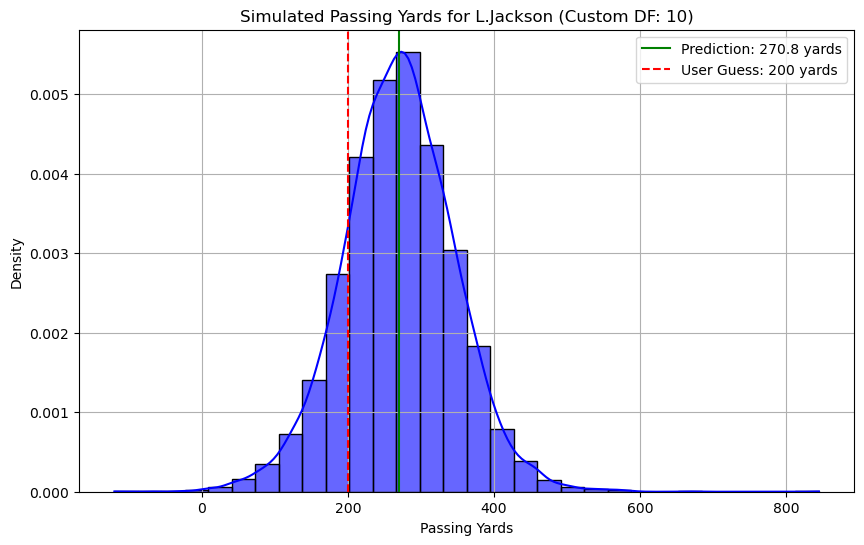

Adjusted probability for <= 100 yards: 1.6400%
Adjusted probability for >= 450 yards: 1.2900%


In [156]:
def calculate_league_wide_std(pred_df):
    """
    Calculates the standard deviation of true passing yards across the entire league.
    :param pred_df: DataFrame containing true passing yards.
    :return: League-wide standard deviation of true passing yards.
    """
    league_wide_std = np.std(pred_df['true_passing_yards'], ddof=1)  # Sample standard deviation (ddof=1)
    print(f"League-wide standard deviation of true passing yards: {league_wide_std:.2f}")
    return league_wide_std

def map_std_to_df(standard_deviation):
    """
    Maps the standard deviation of QB's passing performance to degrees of freedom for the t-distribution.
    :param standard_deviation: The standard deviation of the QB's passing yards or residuals.
    :return: Degrees of freedom (df) for the t-distribution.
    """
    # Example mapping logic
    if standard_deviation > 50:
        return 3  # Very high variance, allow more extreme outcomes
    elif 30 < standard_deviation <= 50:
        return 5  # High variance, some extreme outcomes possible
    elif 20 < standard_deviation <= 30:
        return 7  # Moderate variance
    else:
        return 10  # Low variance, tighter distribution

def simulate_passing_yards_custom_df(qb_name, pred_df, league_wide_std, num_simulations=10000):
    """
    Simulates passing yards using a t-distribution with custom degrees of freedom based on the QB's standard deviation.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards for each QB.
    :param league_wide_std: League-wide standard deviation of true passing yards.
    :param num_simulations: Number of simulations to run.
    :return: Simulated passing yards, predicted passing yards, and degrees of freedom.
    """
    # Extract the predicted passing yards and residual standard deviation for the QB
    qb_data = pred_df[pred_df['passer_player_name'] == qb_name].iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']
    
    # Calculate custom degrees of freedom based on the QB's standard deviation
    df = map_std_to_df(residual_std)
    
    # Simulate passing yards using the t-distribution with custom degrees of freedom
    simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
    return simulations, predicted_passing_yards, df

def plot_qb_simulation_curve_custom_df(qb_name, pred_df, league_wide_std, user_guess=None, num_simulations=10000):
    """
    Plots the distribution (curve) of simulated passing yards for a given QB using custom degrees of freedom,
    and calculates the probability of exceeding the user_guess yards.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param pred_df: DataFrame containing predicted passing yards for each QB.
    :param league_wide_std: League-wide standard deviation of true passing yards.
    :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
    :param num_simulations: Number of simulations to run.
    """
    # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB
    simulations, predicted_passing_yards, df = simulate_passing_yards_custom_df(qb_name, pred_df, league_wide_std, num_simulations)
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the predicted passing yards line
    plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards")
    
    # Add the user guess line and calculate the probability
    probability = None
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        # Calculate the probability of exceeding the user guess
        probability = np.mean(simulations >= user_guess)
        print(f"Probability of {qb_name} throwing at least {user_guess} yards: {probability:.4f}")
    
    # Plot details
    plt.title(f"Simulated Passing Yards for {qb_name} (Custom DF: {df})")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return simulations, probability

def apply_minimum_probability(simulations, min_prob_threshold=0.001, min_yards=100, max_yards=450):
    """
    Applies a minimum probability threshold for extreme outcomes (below min_yards and above max_yards).
    :param simulations: The simulated passing yards.
    :param min_prob_threshold: The minimum probability to apply.
    :param min_yards: The lower bound for passing yards.
    :param max_yards: The upper bound for passing yards.
    :return: Adjusted probabilities with minimum thresholds applied.
    """
    # Calculate probabilities for values below min_yards and above max_yards
    prob_below_min = np.mean(simulations <= min_yards)
    prob_above_max = np.mean(simulations >= max_yards)
    
    # Ensure minimum probabilities for extreme outcomes
    adjusted_prob_below_min = max(prob_below_min, min_prob_threshold)
    adjusted_prob_above_max = max(prob_above_max, min_prob_threshold)
    
    print(f"Adjusted probability for <= {min_yards} yards: {adjusted_prob_below_min:.4%}")
    print(f"Adjusted probability for >= {max_yards} yards: {adjusted_prob_above_max:.4%}")
    
    return adjusted_prob_below_min, adjusted_prob_above_max

# Example usage:
if __name__ == "__main__":
    qb_name = "L.Jackson"
    user_guess = 200
    
    # Calculate league-wide standard deviation
    league_wide_std = calculate_league_wide_std(pred_df)
    
    # Run the simulations with custom degrees of freedom
    simulations, probability = plot_qb_simulation_curve_custom_df(qb_name, pred_df, league_wide_std, user_guess=user_guess)
    
    # Apply minimum probability threshold to extreme outcomes
    min_prob_threshold = 0.001  # Set to 0.1%
    adjusted_prob_below_min, adjusted_prob_above_max = apply_minimum_probability(simulations, min_prob_threshold)

In [ ]:
def simulate_passing_yards_custom_df_rejection(qb_name, week, pred_df, league_wide_std, num_simulations=10000):
    """
    Simulates passing yards using a t-distribution with custom degrees of freedom, re-sampling any negative values.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param week: The week of the simulation.
    :param pred_df: DataFrame containing predicted passing yards for each QB.
    :param league_wide_std: League-wide standard deviation of true passing yards.
    :param num_simulations: Number of simulations to run.
    :return: Simulated passing yards, predicted passing yards, and degrees of freedom.
    """
    # Filter for the specific QB and week
    qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
    if qb_data.empty:
        print(f"No data found for {qb_name} in week {week}.")
        return None, None, None
    
    # Extract the QB data
    qb_data = qb_data.iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']
    
    # Calculate custom degrees of freedom based on the QB's standard deviation
    df = map_std_to_df(residual_std)
    print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
    # Rejection sampling: Resample until all simulated values are non-negative
    simulations = np.empty(num_simulations)
    for i in range(num_simulations):
        sim_value = -1  # Initialize to a negative value
        while sim_value < 0:
            sim_value = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std)
        simulations[i] = sim_value
    
    return simulations, predicted_passing_yards, df

League-wide standard deviation of true passing yards: 68.44
Degrees of freedom (df) for L.Jackson: 10
Probability of L.Jackson throwing at least 200 yards in Week 3: 0.4119


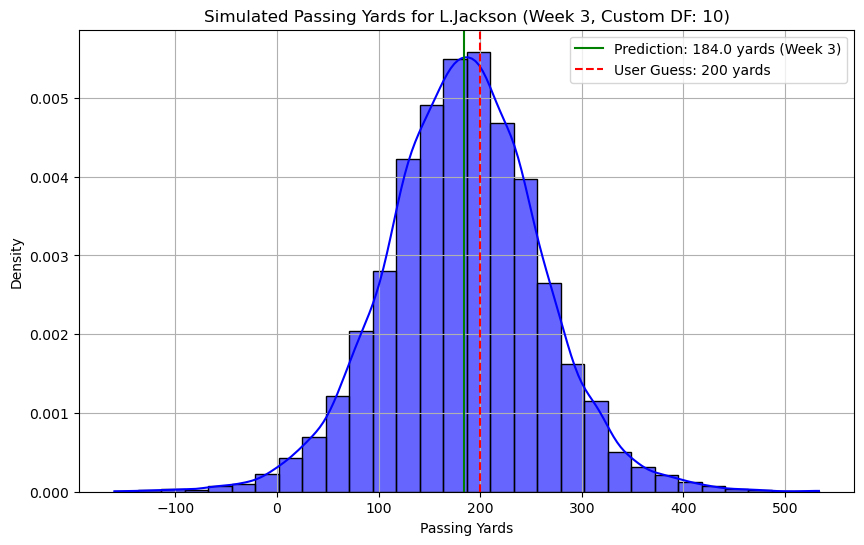

Adjusted probability for <= 100 yards: 12.5700%
Adjusted probability for >= 450 yards: 1.0000%


In [161]:
def calculate_league_wide_std(pred_df):
    """
    Calculates the standard deviation of true passing yards across the entire league.
    :param pred_df: DataFrame containing true passing yards.
    :return: League-wide standard deviation of true passing yards.
    """
    league_wide_std = np.std(pred_df['true_passing_yards'], ddof=1)  # Sample standard deviation (ddof=1)
    print(f"League-wide standard deviation of true passing yards: {league_wide_std:.2f}")
    return league_wide_std

def map_std_to_df(standard_deviation):
    """
    Maps the standard deviation of QB's passing performance to degrees of freedom for the t-distribution.
    :param standard_deviation: The standard deviation of the QB's passing yards or residuals.
    :return: Degrees of freedom (df) for the t-distribution.
    """
    if standard_deviation > 50:
        return 3  # Very high variance, allow more extreme outcomes
    elif 30 < standard_deviation <= 50:
        return 5  # High variance, some extreme outcomes possible
    elif 20 < standard_deviation <= 30:
        return 7  # Moderate variance
    else:
        return 10  # Low variance, tighter distribution

def simulate_passing_yards_custom_df(qb_name, week, pred_df, league_wide_std, num_simulations=10000):
    """
    Simulates passing yards using a t-distribution with custom degrees of freedom based on the QB's standard deviation for the specified week.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param week: The week of the simulation.
    :param pred_df: DataFrame containing predicted passing yards for each QB.
    :param league_wide_std: League-wide standard deviation of true passing yards.
    :param num_simulations: Number of simulations to run.
    :return: Simulated passing yards, predicted passing yards, and degrees of freedom.
    """
    # Filter for the specific QB and week
    qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
    if qb_data.empty:
        print(f"No data found for {qb_name} in week {week}.")
        return None, None, None
    
    # Extract the QB data
    qb_data = qb_data.iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']
    
    # Calculate custom degrees of freedom based on the QB's standard deviation
    df = map_std_to_df(residual_std)
    print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
    # Simulate passing yards using the t-distribution with custom degrees of freedom
    simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
    return simulations, predicted_passing_yards, df

def plot_qb_simulation_curve_custom_df(qb_name, week, pred_df, league_wide_std, user_guess=None, num_simulations=10000):
    """
    Plots the distribution (curve) of simulated passing yards for a given QB using custom degrees of freedom for the specified week,
    and calculates the probability of exceeding the user_guess yards.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param week: The week of the simulation.
    :param pred_df: DataFrame containing predicted passing yards for each QB.
    :param league_wide_std: League-wide standard deviation of true passing yards.
    :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
    :param num_simulations: Number of simulations to run.
    """
    # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
    simulations, predicted_passing_yards, df = simulate_passing_yards_custom_df(qb_name, week, pred_df, league_wide_std, num_simulations)
    
    if simulations is None:
        return None, None
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the predicted passing yards line
    plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
    # Add the user guess line and calculate the probability
    probability = None
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        # Calculate the probability of exceeding the user guess
        probability = np.mean(simulations >= user_guess)
        print(f"Probability of {qb_name} throwing at least {user_guess} yards in Week {week}: {probability:.4f}")
    
    # Plot details
    plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, Custom DF: {df})")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return simulations, probability

def apply_minimum_probability(simulations, min_prob_threshold=0.005, max_prob_threshold=0.01, min_yards=100, max_yards=450):
    """
    Applies a dynamic minimum and maximum probability threshold for extreme outcomes (below min_yards and above max_yards).
    :param simulations: The simulated passing yards.
    :param min_prob_threshold: The minimum probability to apply.
    :param max_prob_threshold: The maximum probability to apply.
    :param min_yards: The lower bound for passing yards.
    :param max_yards: The upper bound for passing yards.
    :return: Adjusted probabilities with minimum thresholds applied.
    """
    # Calculate probabilities for values below min_yards and above max_yards
    prob_below_min = np.mean(simulations <= min_yards)
    prob_above_max = np.mean(simulations >= max_yards)
    
    # Ensure minimum and maximum probabilities for extreme outcomes
    adjusted_prob_below_min = max(prob_below_min, min_prob_threshold)
    adjusted_prob_above_max = max(prob_above_max, max_prob_threshold)
    
    print(f"Adjusted probability for <= {min_yards} yards: {adjusted_prob_below_min:.4%}")
    print(f"Adjusted probability for >= {max_yards} yards: {adjusted_prob_above_max:.4%}")
    
    return adjusted_prob_below_min, adjusted_prob_above_max

# Example usage:
if __name__ == "__main__":
    qb_name = "L.Jackson"
    week = 3  # Example week
    user_guess = 200
    
    # Calculate league-wide standard deviation
    league_wide_std = calculate_league_wide_std(pred_df)
    
    # Run the simulations for the specific week
    simulations, probability = plot_qb_simulation_curve_custom_df(qb_name, week, pred_df, league_wide_std, user_guess=user_guess)
    
    # Apply dynamic minimum/maximum probability thresholds
    if simulations is not None:
        min_prob_threshold = 0.005  # 0.5% minimum probability for extreme low outcomes
        max_prob_threshold = 0.01   # 1% maximum probability for extreme high outcomes
        adjusted_prob_below_min, adjusted_prob_above_max = apply_minimum_probability(simulations, min_prob_threshold, max_prob_threshold)

In [ ]:
#    # Add the user guess line and calculate the probability
#     probability_at_least = None
#     probability_at_most = None
#     if user_guess is not None:
#         plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        
#         # Calculate the probability of exceeding the user guess (at least)
#         probability_at_least = np.mean(simulations >= user_guess)
#         print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
        
#         # Calculate the probability of being at most the user guess
#         probability_at_most = 1 - probability_at_least
#         print(f"Probability of {qb_name} throwing at under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")

In [288]:
# def simulate_passing_yards_with_bounds(qb_name, week, pred_df, league_wide_std, num_simulations=10000, normal_weight=0.8, min_yards=100, max_yards=450):
#     """
#     Simulates passing yards using a combination of normal distribution and t-distribution
#     with hard bounds (e.g., min 100, max 450) to reflect a sportsbook model.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param week: The week of the simulation.
#     :param pred_df: DataFrame containing predicted passing yards for each QB.
#     :param league_wide_std: League-wide standard deviation of true passing yards.
#     :param num_simulations: Number of simulations to run.
#     :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
#     :param min_yards: Minimum passing yards threshold.
#     :param max_yards: Maximum passing yards threshold.
#     :return: Simulated passing yards, predicted passing yards, and degrees of freedom.
#     """
#     # Filter for the specific QB and week
#     qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
#     if qb_data.empty:
#         print(f"No data found for {qb_name} in week {week}.")
#         return None, None, None
    
#     qb_data = qb_data.iloc[0]
#     predicted_passing_yards = qb_data['predicted_passing_yards']
#     residual_std = qb_data['residual_std']  # Use standard deviation of residuals
    
#     # Dynamic adjustment based on QB's variability
#     df = map_std_to_df(residual_std)
#     print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
#     # Expand the standard deviation slightly to smooth the curve
#     expanded_std = residual_std * 1.25  # Adjust this multiplier as needed for smoother odds
    
#     # Generate normal distribution simulations for values close to predicted passing yards
#     normal_simulations = np.random.normal(loc=predicted_passing_yards, scale=expanded_std, size=num_simulations)
    
#     # Generate t-distribution simulations for tail values
#     t_distribution_simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
#     # Combine the two distributions, emphasizing normal near the center and t-distribution for extremes
#     combined_simulations = np.where(np.abs(normal_simulations - predicted_passing_yards) <= expanded_std, 
#                                     normal_simulations * normal_weight + t_distribution_simulations * (1 - normal_weight),
#                                     t_distribution_simulations)
    
#     # Apply bounds to prevent extreme low/high outcomes
#     combined_simulations = np.clip(combined_simulations, min_yards, max_yards)
    
#     return combined_simulations, predicted_passing_yards, df

# def plot_qb_simulation_with_bounds(qb_name, week, pred_df, league_wide_std, user_guess=None, num_simulations=10000, normal_weight=0.8, min_yards=100, max_yards=600):
#     """
#     Plots the distribution (curve) of simulated passing yards for a sportsbook model with hard bounds
#     (e.g., min 100 yards, max 450 yards).
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param week: The week of the simulation.
#     :param pred_df: DataFrame containing predicted passing yards for each QB.
#     :param league_wide_std: League-wide standard deviation of true passing yards.
#     :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
#     :param num_simulations: Number of simulations to run.
#     :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
#     :param min_yards: Minimum passing yards threshold.
#     :param max_yards: Maximum passing yards threshold.
#     """
#     # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
#     simulations, predicted_passing_yards, df = simulate_passing_yards_with_bounds(qb_name, week, pred_df, league_wide_std, num_simulations, normal_weight, min_yards, max_yards)
    
#     if simulations is None:
#         return None, None
    
#     # Plot the distribution of the simulated passing yards
#     plt.figure(figsize=(10, 6))
#     sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
#     # Add the predicted passing yards line
#     plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
#    # Add the user guess line and calculate the probability
#     probability_at_least = None
#     probability_at_most = None
#     if user_guess is not None:
#         plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        
#         # Calculate the probability of exceeding the user guess (at least)
#         probability_at_least = np.mean(simulations >= user_guess)
#         print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
        
#         # Calculate the probability of being at most the user guess
#         probability_at_most = 1 - probability_at_least
#         print(f"Probability of {qb_name} throwing at under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
    
#     # Plot details
#     plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, Sportsbook Model with Bounds)")
#     plt.xlabel("Passing Yards")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return simulations, probability

# # Example usage:
# if __name__ == "__main__":
#     qb_name = "P.Mahomes"
#     week = 3  # Example week
#     user_guess = 339  # User guess for testing
    
#     # Calculate league-wide standard deviation
#     league_wide_std = calculate_league_wide_std(pred_df)
    
#     # Plot the sportsbook-style curve with bounds
#     simulations, probability = plot_qb_simulation_with_bounds(qb_name, week, pred_df, league_wide_std, user_guess=user_guess, normal_weight=0.4, min_yards=100, max_yards=600)

In [273]:
#too narrow
# def simulate_passing_yards_wider_curve(qb_name, week, pred_df, num_simulations=10000, normal_weight=0.6, min_yards=100, max_yards=None):
#     """
#     Simulates passing yards using a combination of normal distribution and t-distribution,
#     with a wider curve for sportsbook-like odds.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param week: The week of the simulation.
#     :param pred_df: DataFrame containing predicted passing yards for each QB.
#     :param num_simulations: Number of simulations to run.
#     :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
#     :param min_yards: Minimum passing yards threshold.
#     :param max_yards: Maximum passing yards threshold (optional).
#     :return: Simulated passing yards, predicted passing yards, and degrees of freedom.
#     """
#     # Filter for the specific QB and week
#     qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
#     if qb_data.empty:
#         print(f"No data found for {qb_name} in week {week}.")
#         return None, None, None
    
#     qb_data = qb_data.iloc[0]
#     predicted_passing_yards = qb_data['predicted_passing_yards']
#     residual_std = qb_data['residual_std']  # Use QB-specific standard deviation of residuals
    
#     # Adjust degrees of freedom based on QB's variability, but give more freedom for broader tails
#     df = map_std_to_df(residual_std) + 5  # Increase the degrees of freedom for a wider curve
#     print(f"Adjusted Degrees of freedom (df) for {qb_name}: {df}")
    
#     # Expand the standard deviation even further for a wider curve
#     expanded_std = residual_std * 1.75  # More expansion for sportsbook-like wider range
    
#     # Generate normal distribution simulations for values near the predicted passing yards
#     normal_simulations = np.random.normal(loc=predicted_passing_yards, scale=expanded_std, size=num_simulations)
    
#     # Generate t-distribution simulations for tail values
#     t_distribution_simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=residual_std, size=num_simulations)
    
#     # Combine the two distributions, with more emphasis on the t-distribution for wider tails
#     combined_simulations = np.where(np.abs(normal_simulations - predicted_passing_yards) <= expanded_std, 
#                                     normal_simulations * normal_weight + t_distribution_simulations * (1 - normal_weight),
#                                     t_distribution_simulations)
    
#     # Clip simulations to avoid impossible values (optional max bound can be applied)
#     combined_simulations = np.clip(combined_simulations, min_yards, max_yards if max_yards else np.inf)
    
#     return combined_simulations, predicted_passing_yards, df

# def plot_qb_simulation_wider_curve(qb_name, week, pred_df, user_guess=None, num_simulations=10000, normal_weight=0.6, min_yards=100, max_yards=None):
#     """
#     Plots the distribution (curve) of simulated passing yards using a wider curve for sportsbook-like odds.
#     :param qb_name: The quarterback's name (e.g., "P.Mahomes").
#     :param week: The week of the simulation.
#     :param pred_df: DataFrame containing predicted passing yards and residuals for each QB.
#     :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
#     :param num_simulations: Number of simulations to run.
#     :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
#     :param min_yards: Minimum passing yards threshold.
#     :param max_yards: Maximum passing yards threshold (optional).
#     """
#     # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
#     simulations, predicted_passing_yards, df = simulate_passing_yards_wider_curve(qb_name, week, pred_df, num_simulations, normal_weight, min_yards, max_yards)
    
#     if simulations is None:
#         return None, None
    
#     # Plot the distribution of the simulated passing yards
#     plt.figure(figsize=(10, 6))
#     sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
#     # Add the predicted passing yards line
#     plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
#     # Add the user guess line and calculate the probability
#     probability = None
#     if user_guess is not None:
#         plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
#         probability = np.mean(simulations >= user_guess)
#         print(f"Probability of {qb_name} throwing at least {user_guess} yards in Week {week}: {probability:.4f}")
    
#     # Plot details
#     plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, Wider Sportsbook Curve)")
#     plt.xlabel("Passing Yards")
#     plt.ylabel("Density")
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return simulations, probability

# # Example usage:
# if __name__ == "__main__":
#     qb_name = "P.Mahomes"
#     week = 3  # Example week
#     user_guess = 300  # User guess for testing
    
#     # Plot the wider curve with sportsbook-style range
#     simulations, probability = plot_qb_simulation_wider_curve(qb_name, week, pred_df, user_guess=user_guess, normal_weight=0.6)

League-wide standard deviation of true passing yards: 68.44
Degrees of freedom (df) for J.Allen: 15
Probability of J.Allen throwing over or exactly 1 yards in Week 3: 0.9998
Probability of J.Allen throwing at under or exactly 1 yards in Week 3: 0.0002


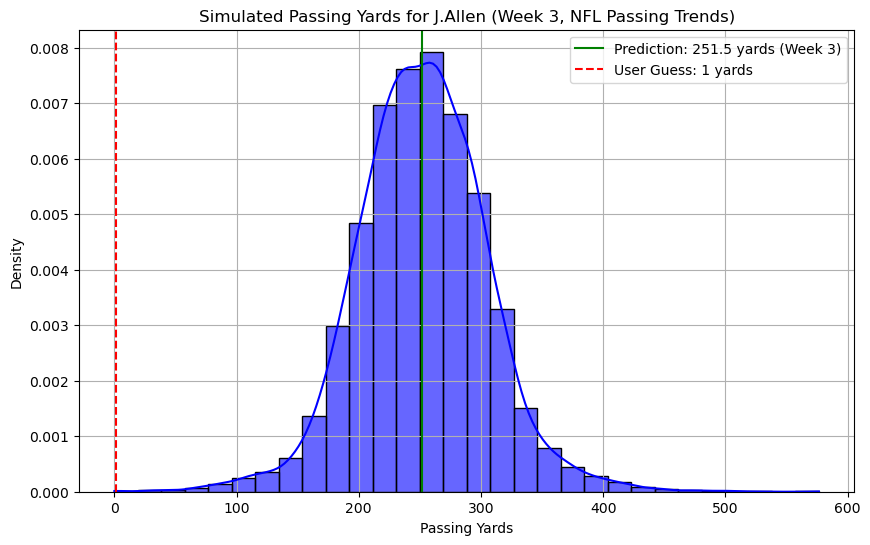

In [289]:
def simulate_passing_yards_nfl_trend(qb_name, week, pred_df, league_wide_std, num_simulations=10000, normal_weight=0.7):
    """
    Simulates passing yards using a combination of normal distribution and t-distribution
    with adjusted NFL trends for realistic sportsbook odds.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param week: The week of the simulation.
    :param pred_df: DataFrame containing predicted passing yards for each QB.
    :param league_wide_std: League-wide standard deviation of true passing yards.
    :param num_simulations: Number of simulations to run.
    :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
    :return: Simulated passing yards, predicted passing yards, and degrees of freedom.
    """
    # Filter for the specific QB and week
    qb_data = pred_df[(pred_df['passer_player_name'] == qb_name) & (pred_df['week'] == week)]
    
    if qb_data.empty:
        print(f"No data found for {qb_name} in week {week}.")
        return None, None, None
    
    qb_data = qb_data.iloc[0]
    predicted_passing_yards = qb_data['predicted_passing_yards']
    residual_std = qb_data['residual_std']  # Use QB-specific standard deviation of residuals
    
    # Set degrees of freedom for t-distribution based on NFL passing trends
    # High degrees of freedom for most QBs (10-15) for smoother tails
    if residual_std < 25:
        df = 15  # Lower variability, more consistent QB
    elif residual_std < 50:
        df = 10  # Moderate variability
    else:
        df = 7   # High variability, bigger tails
    
    print(f"Degrees of freedom (df) for {qb_name}: {df}")
    
    # Expand the standard deviation to widen the curve for more realistic odds
    expanded_std = residual_std * 7  # Adjust for a wider range of realistic NFL outcomes
    
    # Generate normal distribution simulations for values near the predicted passing yards
    normal_simulations = np.random.normal(loc=predicted_passing_yards, scale=expanded_std, size=num_simulations)
    
    # Generate t-distribution simulations for tail values
    t_distribution_simulations = stats.t.rvs(df, loc=predicted_passing_yards, scale=league_wide_std, size=num_simulations)
    
    # Combine the two distributions, with a smooth weighting between them
    combined_simulations = np.where(np.abs(normal_simulations - predicted_passing_yards) <= expanded_std, 
                                    normal_simulations * normal_weight + t_distribution_simulations * (1 - normal_weight),
                                    t_distribution_simulations)
    
    # Clip negative values (set minimum passing yards to 0 or reasonable floor)
    combined_simulations = np.clip(combined_simulations, 0, np.inf)
    
    return combined_simulations, predicted_passing_yards, df

def plot_qb_simulation_nfl_trend(qb_name, week, pred_df, league_wide_std, user_guess=None, num_simulations=10000, normal_weight=0.7):
    """
    Plots the distribution (curve) of simulated passing yards based on NFL trends for sportsbook-like odds.
    :param qb_name: The quarterback's name (e.g., "P.Mahomes").
    :param week: The week of the simulation.
    :param pred_df: DataFrame containing predicted passing yards and residuals for each QB.
    :param league_wide_std: League-wide standard deviation of true passing yards.
    :param user_guess: Optional user guess for passing yards to plot on the curve and calculate probability.
    :param num_simulations: Number of simulations to run.
    :param normal_weight: Weighting of normal distribution near the center (0.0 to 1.0).
    """
    # Get the simulated passing yards, predicted passing yards, and degrees of freedom for the QB and week
    simulations, predicted_passing_yards, df = simulate_passing_yards_nfl_trend(qb_name, week, pred_df, league_wide_std, num_simulations, normal_weight)
    
    if simulations is None:
        return None, None
    
    # Plot the distribution of the simulated passing yards
    plt.figure(figsize=(10, 6))
    sns.histplot(simulations, bins=30, kde=True, color='blue', stat="density", alpha=0.6)
    
    # Add the predicted passing yards line
    plt.axvline(predicted_passing_yards, color='green', linestyle='-', label=f"Prediction: {predicted_passing_yards:.1f} yards (Week {week})")
    
    # Add the user guess line and calculate the probability
       # Add the user guess line and calculate the probability
    probability_at_least = None
    probability_at_most = None
    if user_guess is not None:
        plt.axvline(user_guess, color='red', linestyle='--', label=f"User Guess: {user_guess} yards")
        
        # Calculate the probability of exceeding the user guess (at least)
        probability_at_least = np.mean(simulations >= user_guess)
        print(f"Probability of {qb_name} throwing over or exactly {user_guess} yards in Week {week}: {probability_at_least:.4f}")
        
        # Calculate the probability of being at most the user guess
        probability_at_most = 1 - probability_at_least
        print(f"Probability of {qb_name} throwing at under or exactly {user_guess} yards in Week {week}: {probability_at_most:.4f}")
    
    # Plot details
    plt.title(f"Simulated Passing Yards for {qb_name} (Week {week}, NFL Passing Trends)")
    plt.xlabel("Passing Yards")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return simulations, probability

# Example usage:
if __name__ == "__main__":
    qb_name = "J.Allen"
    week = 3  # Example week
    user_guess = 1 # User guess for testing
    
    # Calculate league-wide standard deviation for fallback use
    league_wide_std = calculate_league_wide_std(pred_df)
    
    # Plot the NFL trend curve for the QB
    simulations, probability = plot_qb_simulation_nfl_trend(qb_name, week, pred_df, league_wide_std, user_guess=user_guess, normal_weight=0.7)